In [148]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix, log_loss, f1_score
from tensorflow.keras.utils import to_categorical

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC

Dataset
--------

In [149]:
train=pd.read_csv(r'C:\Users\smh81\Documents\Dacon_2\Dataset\final_set_train.csv')
test=pd.read_csv(r'C:\Users\smh81\Documents\Dacon_2\Dataset\final_set_test.csv')
submission=pd.read_csv(r'C:\Users\smh81\Documents\Dacon_2\Dataset\sample_submission.csv')

In [150]:
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,ID,ability
0,F,N,N,N,103500.0,Pensioner,Higher education,Married,House / apartment,21701,0,0,1,0,Nan,2.0,24.0,0.0,0.0,4.769365
1,F,N,N,N,103500.0,Pensioner,Higher education,Married,House / apartment,21701,0,0,1,0,Nan,2.0,28.0,0.0,0.0,4.769365
2,F,N,N,N,103500.0,Pensioner,Higher education,Married,House / apartment,21701,0,0,1,0,Nan,2.0,30.0,2.0,0.0,4.769365
3,F,N,N,N,103500.0,Pensioner,Higher education,Single / not married,House / apartment,24543,0,0,0,0,Nan,1.0,17.0,2.0,1.0,4.217088
4,F,N,N,N,103500.0,Pensioner,Higher education,Single / not married,House / apartment,24543,0,0,0,0,Nan,1.0,39.0,2.0,1.0,4.217088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,M,Y,Y,Y,292500.0,Working,Secondary / secondary special,Married,House / apartment,14150,401,0,0,0,Laborers,6.0,24.0,2.0,8757.0,20.101711
26453,M,Y,Y,Y,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,11384,2727,0,0,0,Managers,2.0,19.0,1.0,8758.0,14.350507
26454,M,Y,Y,Y,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,11384,2727,0,0,0,Managers,2.0,21.0,1.0,8758.0,14.350507
26455,M,Y,Y,Y,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,11384,2727,0,0,0,Managers,2.0,46.0,0.0,8758.0,14.350507


In [151]:
# corr 시각화
def corr_heatmap(dataset):
    """[상관관계 그래프]

    Args:
        dataset ([DataFrame]): [데이터프래임을 입력해주세요]
    """
    mask_ut=np.triu(np.ones(dataset.corr().shape)).astype(np.bool) 
    sns.heatmap(dataset.corr(), annot = True, cmap = 'RdYlBu_r', cbar_kws={"shrink": .5}, 
                annot_kws={"size": 6}, linewidths=.5, mask=mask_ut)
    plt.figure(figsize=(40,40))
    plt.show()

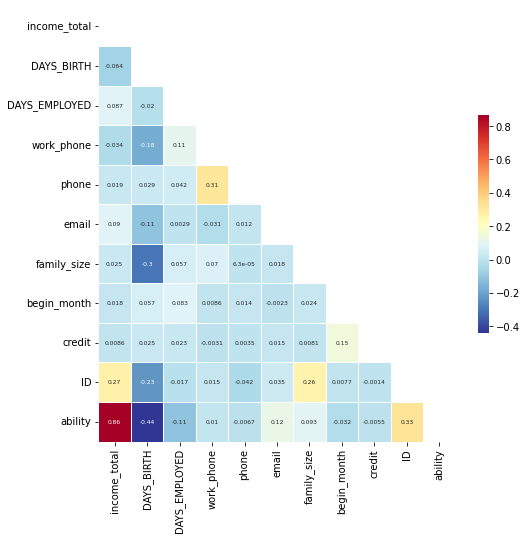

<Figure size 2880x2880 with 0 Axes>

In [152]:
corr_heatmap(train)

In [153]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  object 
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  work_phone     26457 non-null  int64  
 12  phone          26457 non-null  int64  
 13  email          26457 non-null  int64  
 14  occyp_type     26457 non-null  object 
 15  family_size    26457 non-null  float64
 16  begin_month    26457 non-null  float64
 17  credit         26457 non-null  float64
 18  ID    

In [154]:
# numerical_feats = ['income_total','DAYS_BIRTH','DAYS_EMPLOYED','begin_month','ability']
# categorical_feats = ['family_size','gender','car','reality','child_num','income_type', 'edu_type','family_type', 'house_type', 'work_phone', 'phone', 'email', 'occyp_type']

# print("Number of Numerical features: ", len(numerical_feats))
# print("Number of Categorical features: ", len(categorical_feats))

# train['ID'] = train['ID'].astype('int64')
# test['ID'] = test['ID'].astype('int64')

In [155]:
numerical_feats = ['income_total','DAYS_BIRTH','DAYS_EMPLOYED','begin_month','ability']
categorical_feats = ['family_size','ID']
onehot_feats = ['gender','car','reality','child_num','income_type', 'edu_type','family_type', 'house_type', 'work_phone', 'phone', 'email', 'occyp_type']

print("Number of Numerical features: ", len(numerical_feats))
print("Number of Categorical features: ", len(categorical_feats))
print("Number of Categorical features: ", len(onehot_feats))


# train['ID'] = train['ID'].astype('int64')
# test['ID'] = test['ID'].astype('int64')

Number of Numerical features:  5
Number of Categorical features:  2
Number of Categorical features:  12


In [156]:
# for i in categorical_feats:
#     train[i] = train[i].astype('object')
#     test[i] = test[i].astype('object')

Log Scale
------

In [157]:
# for df in [train,test]:
#     df['income_total'] = np.log1p(1+df['income_total'])
#     # df['income_mean'] = np.log1p(1+df['income_mean'])

MinMaxScaler
--------

In [158]:
income_train = train[['income_total']]
income_test = test[['income_total']]

In [159]:
#작업 전 minmaxscaler 처리
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler = MinMaxScaler()
MinMaxScaler.fit(income_train)
income_minmax = MinMaxScaler.transform(income_train)

train['income_minmax'] = income_minmax 

In [160]:
from sklearn.preprocessing import MinMaxScaler
MinMaxScaler = MinMaxScaler()
MinMaxScaler.fit(income_test)
income_minmax = MinMaxScaler.transform(income_test)

test['income_minmax'] = income_minmax 

In [161]:
train.drop(columns=['income_total'], inplace=True)
test.drop(columns=['income_total'],inplace=True)

OrdinalEncoder
-----

In [162]:
encoder = OrdinalEncoder()
train[categorical_feats] = encoder.fit_transform(train[categorical_feats])
test[categorical_feats] = encoder.transform(test[categorical_feats])

OnehotEncoder
------

In [163]:
train = pd.get_dummies(train,columns=onehot_feats,drop_first=True)
test = pd.get_dummies(test,columns=onehot_feats,drop_first=True)

Clusterling
------

In [164]:
# kmeans_train = train.drop(['credit'], axis=1)
# kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
# train['cluster'] = kmeans.predict(kmeans_train)
# test['cluster'] = kmeans.predict(test)

StandardScale
----
- 이미 로그변환을 진행한 income_total을 제외한 나머지 numeric 컬럼 정규화

In [165]:
numerical_feats.remove('income_total')
# numerical_feats.remove('income_mean')

scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

Modeling-Catboost 1
----

In [166]:
# train_data = train.drop('credit', axis=1)
# target = train['credit']
# test_x = test

In [167]:
# X_train, X_val, y_train, y_val = train_test_split(train_data, target, train_size=0.75, random_state=42)

# cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']

# train_pool = Pool(X_train, y_train, cat_features=cat_cols)
# eval_pool = Pool(X_val, y_val, cat_features=cat_cols)

In [168]:
# params = {'iterations':200,
#           'random_seed':63,
#           'learning_rate':0.02,
#           'loss_function':'Logloss', ## 사실 Default 값은 Logloss 이다. 만약 CatBoostRegressor 였으면, RMSE 이다.
#           'custom_metric':['Logloss','AUC'],##, '
#           'early_stopping_rounds':20,
#           'use_best_model': True,
#           'task_type':"GPU",
#           'bagging_temperature':1,
#           'verbose':False}

In [169]:
# cat_clf = CatBoostClassifier(early_stopping_rounds=20,random_state=44)
# cat_clf.fit(train_pool, eval_set=eval_pool, plot=True) ## ,save_snapshot=True
# y_pred=cat_clf.predict_proba(X_val)

# print("훈련 세트 정확도: {:.3f}".format(cat_clf.score(X_train, y_train)))
# print("테스트 세트 정확도: {:.3f}".format(cat_clf.score(X_val, y_val)))

# print(f"log_loss: {log_loss(to_categorical(y_val), y_pred)}")

In [170]:
# # 특성 중요도 시각화
# plt.figure(figsize=(10,10))
# feature_names = list(train_data.columns)
# sns.barplot(cat_clf.feature_importances_, y=feature_names)

In [171]:
# def run_kfold(cat_clf):
#     folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=44)
#     outcomes=[]
#     sub=np.zeros((test_x.shape[0], 3))  
#     for n_fold, (train_index, val_index) in enumerate(folds.split(train_data, target)):
#         X_train, X_val = train_data.iloc[train_index], train_data.iloc[val_index]
#         y_train, y_val = target.iloc[train_index], target.iloc[val_index]
#         cat_clf.fit(X_train, y_train)
        
#         predictions=cat_clf.predict_proba(X_val)
        
#         logloss=log_loss(to_categorical(y_val), predictions)
#         outcomes.append(logloss)
#         print(f"FOLD {n_fold} : logloss:{logloss}")
        
#         sub+=cat_clf.predict_proba(test_x)
        
        
#     mean_outcome=np.mean(outcomes)
    
#     print("Mean:{}".format(mean_outcome))
#     return sub/folds.n_splits

# my_submission = run_kfold(cat_clf)

Modeling-Catboost 2
----

In [172]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test

#재헌쓰모델 catboosting
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

'''print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)'''

# 모델 학습
cat_clf=CatBoostClassifier()
cat_clf.fit(X_train, y_train)
y_pred=cat_clf.predict_proba(X_val)

# 평가
print("훈련 세트 정확도: {:.3f}".format(cat_clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(cat_clf.score(X_val, y_val)))

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Learning rate set to 0.092151
0:	learn: 1.0472072	total: 15.5ms	remaining: 15.4s
1:	learn: 1.0065985	total: 26.7ms	remaining: 13.3s
2:	learn: 0.9731562	total: 39.6ms	remaining: 13.2s
3:	learn: 0.9463378	total: 51ms	remaining: 12.7s
4:	learn: 0.9243290	total: 62.5ms	remaining: 12.4s
5:	learn: 0.9060535	total: 77.2ms	remaining: 12.8s
6:	learn: 0.8907482	total: 89.8ms	remaining: 12.7s
7:	learn: 0.8779037	total: 102ms	remaining: 12.6s
8:	learn: 0.8670096	total: 115ms	remaining: 12.7s
9:	learn: 0.8577966	total: 131ms	remaining: 12.9s
10:	learn: 0.8502048	total: 146ms	remaining: 13.1s
11:	learn: 0.8440874	total: 159ms	remaining: 13.1s
12:	learn: 0.8382669	total: 170ms	remaining: 12.9s
13:	learn: 0.8338087	total: 190ms	remaining: 13.4s
14:	learn: 0.8302484	total: 209ms	remaining: 13.7s
15:	learn: 0.8266027	total: 223ms	remaining: 13.7s
16:	learn: 0.8235001	total: 248ms	remaining: 14.4s
17:	learn: 0.8206014	total: 268ms	remaining: 14.6s
18:	learn: 0.8182783	total: 294ms	remaining: 15.2s
19:	le

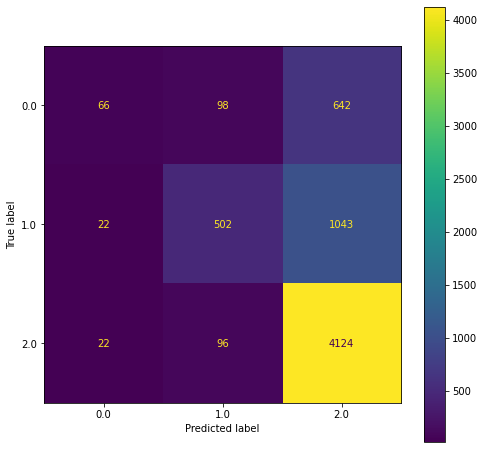

In [173]:
plt.rcParams['figure.figsize'] = (8,8)
plot_confusion_matrix(cat_clf,X_val, y_val)
plt.show()

In [174]:
def run_kfold(cat_clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        cat_clf.fit(X_train, y_train)
        
        predictions=cat_clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=cat_clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(cat_clf)

Learning rate set to 0.092455
0:	learn: 1.0467474	total: 18.5ms	remaining: 18.5s
1:	learn: 1.0060349	total: 35.7ms	remaining: 17.8s
2:	learn: 0.9723678	total: 52.4ms	remaining: 17.4s
3:	learn: 0.9452974	total: 68.1ms	remaining: 17s
4:	learn: 0.9229579	total: 83.8ms	remaining: 16.7s
5:	learn: 0.9047373	total: 107ms	remaining: 17.7s
6:	learn: 0.8893326	total: 126ms	remaining: 17.9s
7:	learn: 0.8764959	total: 140ms	remaining: 17.3s
8:	learn: 0.8657055	total: 153ms	remaining: 16.9s
9:	learn: 0.8564819	total: 168ms	remaining: 16.6s
10:	learn: 0.8488419	total: 184ms	remaining: 16.5s
11:	learn: 0.8426600	total: 200ms	remaining: 16.4s
12:	learn: 0.8368172	total: 213ms	remaining: 16.2s
13:	learn: 0.8324853	total: 239ms	remaining: 16.8s
14:	learn: 0.8286999	total: 262ms	remaining: 17.2s
15:	learn: 0.8250489	total: 282ms	remaining: 17.4s
16:	learn: 0.8219252	total: 297ms	remaining: 17.2s
17:	learn: 0.8192635	total: 317ms	remaining: 17.3s
18:	learn: 0.8168360	total: 332ms	remaining: 17.1s
19:	lear

<AxesSubplot:>

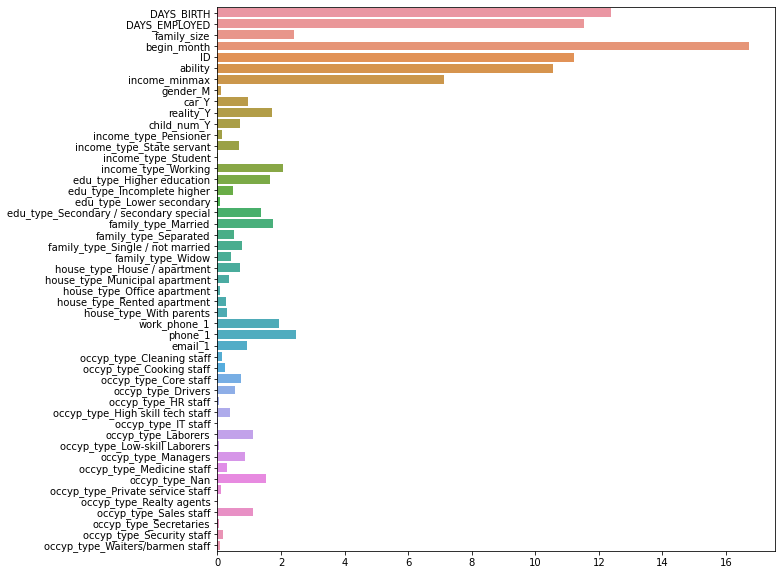

In [175]:
# 특성 중요도 시각화
plt.figure(figsize=(10,10))
feature_names = list(train_x.columns)
sns.barplot(cat_clf.feature_importances_, y=feature_names)

Submission
---

In [176]:
sub = pd.read_csv(r'C:\Users\smh81\Documents\Dacon_2\Dataset\sample_submission.csv')

In [177]:
sub.iloc[:, 1:] = my_submission
sub

,index,0,1,2
0,26457,0.205903,0.770966,0.023131
1,26458,0.146160,0.146812,0.707028
2,26459,0.138956,0.165507,0.695537
3,26460,0.163666,0.211207,0.625126
4,26461,0.044354,0.091067,0.864579
...,...,...,...,...
9995,36452,0.191600,0.177286,0.631114
9996,36453,0.235557,0.750937,0.013506
9997,36454,0.121335,0.134965,0.743700
9998,36455,0.125982,0.142033,0.731985


In [48]:
sub.to_csv(r'C:\Users\smh81\Documents\Dacon_2\Dataset\submission_cat_7422.csv', index=False)

Modeling-Stacking Ensemble
---

In [52]:
target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test
random_state = 42

In [61]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=11, random_state = random_state)),
    ('svr', make_pipeline(StandardScaler(),
                          LinearSVC(random_state = random_state))),
    ('cat', CatBoostClassifier(random_state = random_state, learning_rate = 0.08)),
    ('LGB', LGBMClassifier(random_state = random_state, learning_rate = 0.09, n_estimators = 115)),
    ('XGB', XGBClassifier(random_state = random_state))
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    stratify=y, test_size=0.25,
                                                    random_state = random_state)
clf.fit(X_train, y_train).score(X_val, y_val)

0:	learn: 1.0537214	total: 33ms	remaining: 33s
1:	learn: 1.0169117	total: 56.2ms	remaining: 28s
2:	learn: 0.9864045	total: 75.6ms	remaining: 25.1s
3:	learn: 0.9608337	total: 92.5ms	remaining: 23s
4:	learn: 0.9391876	total: 107ms	remaining: 21.4s
5:	learn: 0.9205734	total: 126ms	remaining: 20.8s
6:	learn: 0.9048869	total: 166ms	remaining: 23.6s
7:	learn: 0.8913365	total: 192ms	remaining: 23.7s
8:	learn: 0.8796443	total: 222ms	remaining: 24.5s
9:	learn: 0.8698807	total: 253ms	remaining: 25.1s
10:	learn: 0.8614113	total: 284ms	remaining: 25.5s
11:	learn: 0.8542885	total: 308ms	remaining: 25.4s
12:	learn: 0.8477040	total: 340ms	remaining: 25.8s
13:	learn: 0.8419736	total: 373ms	remaining: 26.2s
14:	learn: 0.8371550	total: 392ms	remaining: 25.7s
15:	learn: 0.8330422	total: 415ms	remaining: 25.5s
16:	learn: 0.8296358	total: 434ms	remaining: 25.1s
17:	learn: 0.8262883	total: 472ms	remaining: 25.7s
18:	learn: 0.8233249	total: 500ms	remaining: 25.8s
19:	learn: 0.8206803	total: 520ms	remaining: 

KeyboardInterrupt: 

In [ ]:
y_pred = clf.predict_proba(X_test)
print(y_pred.shape)
y_val_pred = clf.predict_proba(X_val)

In [ ]:
plt.rcParams['figure.figsize'] = (8,8)
plot_confusion_matrix(clf, X_val, y_val)
plt.show()

In [ ]:
submission.loc[:,1:] = y_pred

In [ ]:
submission

In [ ]:
sub.to_csv(r'C:\Users\smh81\Documents\Dacon_2\Dataset\submission_stack_7416.csv', index=False)